# Importing Required Libraries

First, we are importing the libraries and modules that are required for running this notebook.

In [1]:
# import general packages
import os
import sys

import pandas as pd
import torch
from dpu_utils.utils.richpath import RichPath
from tqdm.notebook import tqdm

# Setting up local details:
# This should be the location of the checkout of the THEMAP repository:
repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [2]:
from third_party.otdd.otdd.pytorch.datasets import MolDataset, load_molecule_data
from third_party.otdd.otdd.pytorch.distance import DatasetDistance

ot.gpu not found - coupling computation will be in cpu


In [3]:
# import visualization packages
%matplotlib inline

import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt

from themap.data import MoleculeDataset, ProteinDataset

light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 20,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

# Create source and target datasets (Data)

In [4]:
source_dataset_path = RichPath.create(os.path.join(DATASET_PATH, "train", "CHEMBL1023359.jsonl.gz"))
target_dataset_path = RichPath.create(os.path.join(DATASET_PATH, "test", "CHEMBL2219358.jsonl.gz"))

source_dataset = MoleculeDataset.load_from_file(source_dataset_path)
target_dataset = MoleculeDataset.load_from_file(target_dataset_path)

In [5]:
Molecule_Feaurizer = widgets.Dropdown(
    options=["gin_supervised_infomax", "gin_supervised_masking", "gin_supervised_edgepred"],
    value="gin_supervised_infomax",
    description="Molecule Featurizer:",
    disabled=False,
)

In [6]:
Molecule_Feaurizer

Dropdown(description='Molecule Featurizer:', options=('gin_supervised_infomax', 'gin_supervised_masking', 'gin…

In [7]:
## compute and load the embeddings
molecule_feaurizer = Molecule_Feaurizer.value
source_features = source_dataset.get_dataset_embedding(molecule_feaurizer)
target_features = target_dataset.get_dataset_embedding(molecule_feaurizer)
assert source_features.shape[1] == target_features.shape[1]

In [8]:
source_dataset_otdd = MolDataset(source_dataset)
target_dataset_otdd = MolDataset(target_dataset)

In [9]:
source_dataset_loader = load_molecule_data(source_dataset)
target_dataset_loader = load_molecule_data(target_dataset)

In [ ]:
# Instantiate distance
dist = DatasetDistance(
    source_dataset_loader,
    target_dataset_loader,
    inner_ot_method="exact",
    debiased_loss=True,
    p=2,
    entreg=1e-1,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

d = dist.distance(maxsamples=1000)
print(f"OTDD(src,tgt)={d}")

## Calculate chemcial distance between target datasets with all the source datasets

In [ ]:
import glob

source_datasets_path = glob.glob(os.path.join(DATASET_PATH, "train", "CHEMBL*"))
target_datasets_path = glob.glob(os.path.join(DATASET_PATH, "test", "CHEMBL*"))
chem_distances = {}
for target_path in tqdm(target_datasets_path):
    chem_distance = {}
    target_dataset_path = RichPath.create(target_path)
    target_dataset = MoleculeDataset.load_from_file(target_dataset_path)
    target_features = target_dataset.get_dataset_embedding(molecule_feaurizer)
    target_dataset_otdd = MolDataset(target_dataset)
    target_dataset_loader = load_molecule_data(target_dataset)
    for source_path in source_datasets_path:
        source_dataset_path = RichPath.create(source_path)
        source_dataset = MoleculeDataset.load_from_file(source_dataset_path)
        source_features = source_dataset.get_dataset_embedding(molecule_feaurizer)
        source_dataset_otdd = MolDataset(source_dataset)
        source_dataset_loader = load_molecule_data(source_dataset)

        dist = DatasetDistance(
            source_dataset_loader,
            target_dataset_loader,
            inner_ot_method="exact",
            debiased_loss=True,
            p=2,
            entreg=1e-1,
            device="cuda" if torch.cuda.is_available() else "cpu",
        )

        d = dist.distance(maxsamples=1000)
        print(f"OTDD({source_dataset.task_id},{target_dataset.task_id})= {d}")
        chem_distance[source_dataset.task_id] = d.cpu().item()
    chem_distances[target_dataset.task_id] = chem_distance

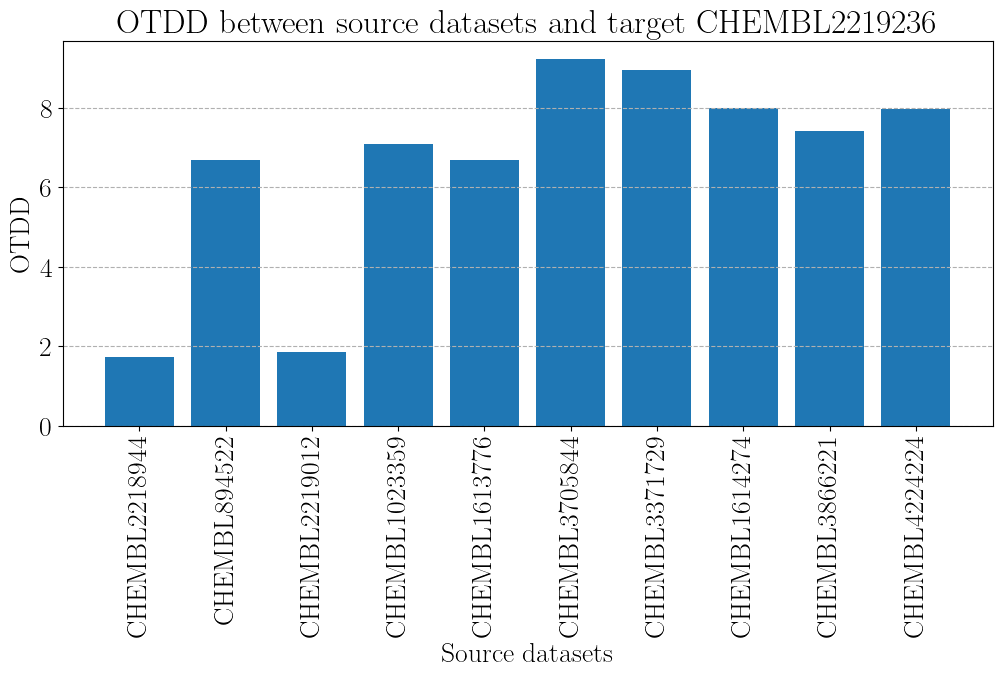

In [12]:
## Choose your target from chem_distances.keys()
your_tasks = "CHEMBL2219236"
chem_dist = chem_distances[your_tasks]
fig = plt.figure(figsize=(12, 5))
plt.bar(chem_dist.keys(), chem_dist.values())
plt.xlabel("Source datasets")
plt.ylabel("OTDD")
plt.title(f"OTDD between source datasets and target {your_tasks}")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=1.0)
plt.show()

In [15]:
chem_distances.keys()

dict_keys(['CHEMBL2219236', 'CHEMBL1963831', 'CHEMBL2219358'])

## Calculate protein distance between target datasets with all the source datasets

In [13]:
Protein_Feaurizer = widgets.Dropdown(
    options=[
        "esm2_t6_8M_UR50D",
        "esm2_t12_35M_UR50D",
        "esm2_t30_150M_UR50D",
        "esm2_t33_650M_UR50D",
        "esm2_t36_3B_UR50D",
    ],
    value="esm2_t33_650M_UR50D",
    description="Protein Featurizer:",
    disabled=False,
)

In [14]:
Protein_Feaurizer

Dropdown(description='Protein Featurizer:', index=3, options=('esm2_t6_8M_UR50D', 'esm2_t12_35M_UR50D', 'esm2_…

In [15]:
source_protein = ProteinDataset.load_from_file("datasets/train/train_proteins.fasta")
target_protein = ProteinDataset.load_from_file("datasets/test/test_proteins.fasta")

In [16]:
protein_featurizer = Protein_Feaurizer.value
source_protein_features = source_protein.get_features(protein_featurizer)
target_protein_features = target_protein.get_features(protein_featurizer)

In [17]:
from scipy.spatial.distance import cdist

dist = cdist(source_protein.features, target_protein.features)

In [18]:
prot_distances = {}
for i, target_prot in enumerate(target_protein.task_id):
    prot_distance = {}
    for j, source_prot in enumerate(source_protein.task_id):
        prot_distance[source_prot] = dist[j, i]
    prot_distances[target_prot] = prot_distance

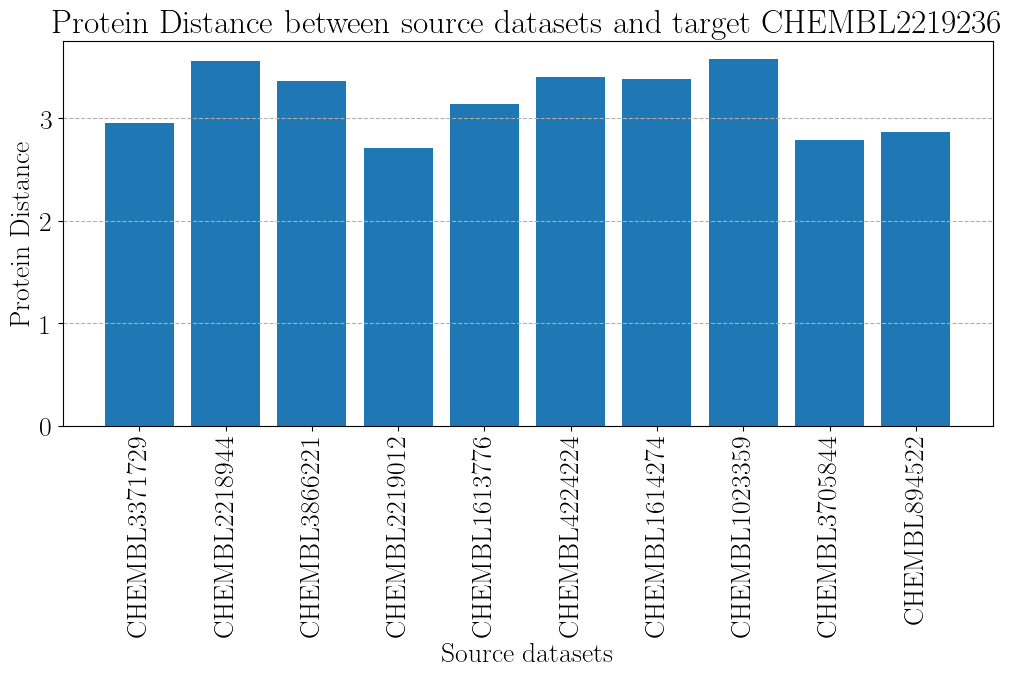

In [24]:
## Choose your target from chem_distances.keys()
your_tasks = "CHEMBL2219236"
prot_dist = prot_distances[your_tasks]
fig = plt.figure(figsize=(12, 5))
plt.bar(prot_dist.keys(), prot_dist.values())
plt.xlabel("Source datasets")
plt.ylabel("Protein Distance")
plt.title(f"Protein Distance between source datasets and target {your_tasks}")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=1.0)
plt.show()

## Combine Two Distances

Now, we can answer to the following questions:
- Given a target task, what is the closest source task in terms of chemical and protein distances?
- Given the source tasks, which target task is hardest to transfer to in terms of chemical and protein space?
- Given a target task and source tasks, how to pick the k nearset source tasks fo transfer learning?

So, let's answer to this questions in the following sections.

In [42]:
chem_df = pd.DataFrame.from_dict(chem_distances)
prot_df = pd.DataFrame.from_dict(prot_distances)

In [69]:
## Given a target task, what is the closest source task in terms of chemical and protein distances?
your_task = "CHEMBL2219236"

chem_distance = chem_df[your_task]
prot_distance = prot_df[your_task]

normalized_chem_distance = (chem_distance - chem_distance.min()) / (chem_distance.max() - chem_distance.min())
normalized_prot_distance = (prot_distance - prot_distance.min()) / (prot_distance.max() - prot_distance.min())
normalized_prot_distance = normalized_prot_distance.reindex(normalized_chem_distance.index)
normalized_comb_distance = (normalized_chem_distance + normalized_prot_distance) / 2


print(f"Closest source task in terms of chemical distance: {chem_distance.idxmin()}")
print(f"Closest source task in terms of protein distance: {prot_distance.idxmin()}")
print(
    f"Closest source task in terms of combination of chemical and protein distance: {normalized_comb_distance.idxmin()}"
)

Closest source task in terms of chemical distance: CHEMBL2218944
Closest source task in terms of protein distance: CHEMBL2219012
Closest source task in terms of combination of chemical and protein distance: CHEMBL2219012


In [91]:
## Given the source tasks, which target task is hardest to transfer to in terms of chemical and protein space?
## Answering this question require to define hardness, which we consider here as the average of k-nearest source tasks.
k = 3

target_tasks = chem_df.columns
source_tasks = chem_df.index

hardness_all = {}
for target_task in target_tasks:
    hardness = {}
    chem_distance = chem_df[target_task]
    prot_distance = prot_df[target_task]

    chem_distance = chem_distance.sort_values()
    prot_distance = prot_distance.sort_values()

    hardness["EXT_CHEM"] = chem_distance[:k].sum() / k
    hardness["EXT_PROT"] = prot_distance[:k].sum() / k

    hardness_all[target_task] = hardness

hardness_df = pd.DataFrame.from_dict(hardness_all).T
hardness_df["all"] = (hardness_df["EXT_CHEM"] + hardness_df["EXT_PROT"]) / 2

print(f"Easiest target task in terms of chemical distance: {hardness_df['EXT_CHEM'].idxmin()}")
print(f"Easiest target task in terms of protein distance: {hardness_df['EXT_PROT'].idxmin()}")
print(
    f"Easiest target task in terms of combination of chemical and protein distance: {hardness_df['all'].idxmin()}"
)

Easiest target task in terms of chemical distance: CHEMBL2219236
Easiest target task in terms of protein distance: CHEMBL2219358
Easiest target task in terms of combination of chemical and protein distance: CHEMBL2219358


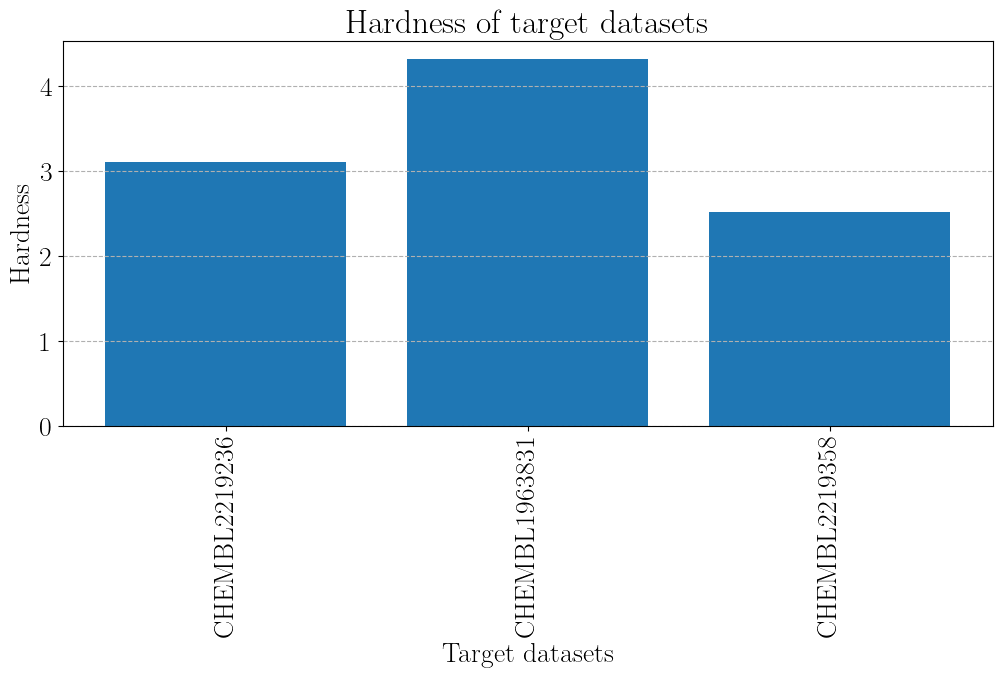

In [93]:
plt.figure(figsize=(12, 5))
plt.bar(hardness_df.index, hardness_df["all"])
plt.xlabel("Target datasets")
plt.ylabel("Hardness")
plt.title("Hardness of target datasets")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=1.0)
plt.show()

In [103]:
## Given a target task and source tasks, how to pick the k nearset source tasks fo transfer learning?
## Given the source tasks, which target task is hardest to transfer to in terms of chemical and protein space?
## Answering this question require to define hardness, which we consider here as the average of k-nearest source tasks.
k = 3

target_tasks = chem_df.columns
source_tasks = chem_df.index

closest_tasks = {}
for target_task in target_tasks:
    closest = {}
    chem_distance = chem_df[target_task]
    prot_distance = prot_df[target_task]

    chem_distance = chem_distance.sort_values()
    prot_distance = prot_distance.sort_values()

    closest["EXT_CHEM"] = chem_distance[:k].index.to_list()
    closest["EXT_PROT"] = prot_distance[:k].index.to_list()

    closest_tasks[target_task] = closest

closest_df = pd.DataFrame.from_dict(closest_tasks).T